In [1]:
import sys
import time
import h5py
import pygrib
import numpy as np
from datetime import datetime, timedelta

In [72]:
import scipy.interpolate as spint
from scipy.spatial import Delaunay
import itertools

In [63]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

grib name example

*  25:Total Precipitation:kg m**-2 (accum):polar_stereographic:surface:level 0:fcst time 0-6 hrs (accum):from 202301010000:Probability of event above upper limit (> 0.254)
* 38:Total Precipitation:kg m**-2 (accum):polar_stereographic:surface:level 0:fcst time 0-6 hrs (accum):from 202301010000

In [64]:
# MRMS lat/lon
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]

**National blend has irragular grids**

In [69]:
filename = '/glade/campaign/cisl/aiml/ksha/NBlend_2023/blend.t00z.qmd.f024.co.grib2'
with pygrib.open(filename) as grbio:
    lat_blend, lon_blend = apcp_temp = grbio[2].latlons()

In [74]:
def interp_weights(xy, uv, d=2):
    tri = Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [75]:
# compute interpolation weights from National blend grids to 0.1 deg grids
vtx, wts = interp_weights(np.vstack([lon_blend.ravel(), lat_blend.ravel()]).T, 
                          np.vstack([lon_01.ravel(), lat_01.ravel()]).T)

In [56]:
q_bins_blend = np.arange(0.01, 1, 0.01)
grid_shape = lat_01.shape
N_bins = len(q_bins_blend)

In [76]:
APCP_q = np.empty((N_bins,)+grid_shape)
APCP_q[...] = np.nan

# append all available grbio info until indices run out-of-bound
filename = '/glade/campaign/cisl/aiml/ksha/NBlend_2023/blend.t00z.qmd.f024.co.grib2'

start_time = time.time()

with pygrib.open(filename) as grbio:
    for i, ind in enumerate(range(2, 101, 1)):
        apcp_temp = grbio[ind].values
        
        apcp_interp = interpolate(apcp_temp.ravel(), vtx, wts)
        apcp_interp[apcp_interp<0] = 0
        
        APCP_q[i, ...] = apcp_interp.reshape(grid_shape)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 26.225807428359985 seconds ---


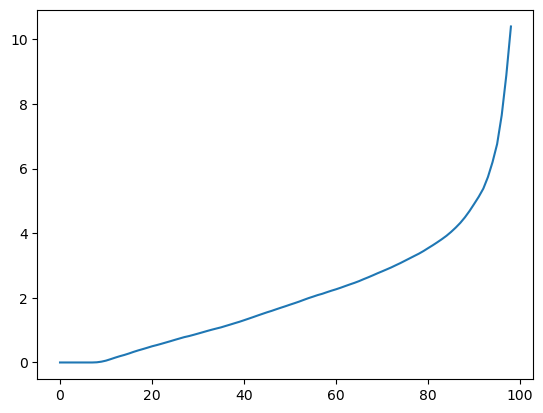

In [83]:
plt.plot(APCP_q[:, 150, 150])